In [1]:
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize
import numpy as np
from scipy.special import gamma,betaincinv
from scipy.stats import rv_continuous


import sys
sys.path.append('../')
from src.rapidbetaprocess2 import rapidbeta
from src.threebetaprocess import threebeta

# 3 parameters beta 

In [2]:
c=3
b=1
a=0.5

def nu3BP(w):
    mask = (w > 0) & (w < 1)
    toreturn=np.zeros_like(w)
    toreturn[mask] = c*gamma(1+b)/gamma(1-a)/gamma(a+b)*w[mask]**(a-1)*(1-w[mask])**(a+b-1)
    return toreturn
    

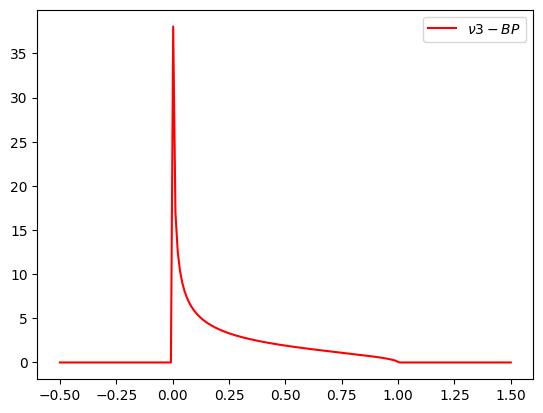

In [3]:
X=np.linspace(-0.5,1.5,200)
plt.plot(X,nu3BP(X),label=r"$\nu3-BP$",color="red")
plt.legend()

In [4]:
def tailor(f, x_array):
    x_array = np.atleast_1d(x_array)
    
    def single_integral(x):
        if x > 1:
            return np.nan  # or raise ValueError
        result, _ = integrate.quad(f, x, 1)
        return result

    vec_integral = np.vectorize(single_integral)
    return vec_integral(x_array)

def scalar_nu3BP(w):
    """Scalar wrapper for nu3BP, safe for use with `quad`."""
    return nu3BP(np.array([w]))

def barnu3BP(x):
    return tailor(scalar_nu3BP, x)

/var/folders/f1/j6lff07s4rz0h9k3nf2mqttm0000gn/T/ipykernel_48240/496583595.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = integrate.quad(f, x, 1)


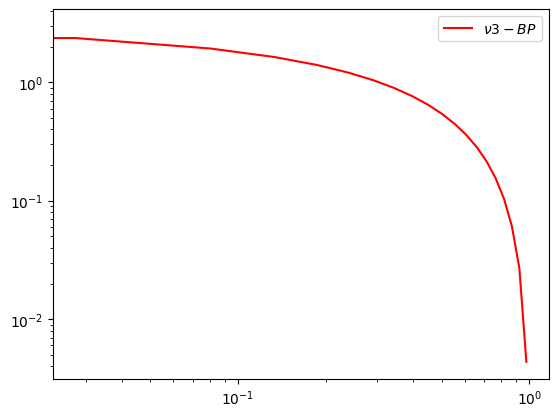

In [5]:
X=np.linspace(-0.5,10,200)
plt.loglog(X,barnu3BP(X),label=r"$\nu3-BP$",color="red")
plt.legend()

In [6]:
def barnu3BP_inv(y, tol=1e-6):
    # Root-finding target: barnu3BP(x) - y = 0
    def objective(x):
        return barnu3BP(x) - y
    return optimize.bisect(objective, 0, 1, xtol=tol)
def vectorised_barnu3BP_inv(y_array, tol=1e-6):
    y_array = np.atleast_1d(y_array)
    return np.array([barnu3BP_inv(y, tol=tol) for y in y_array])

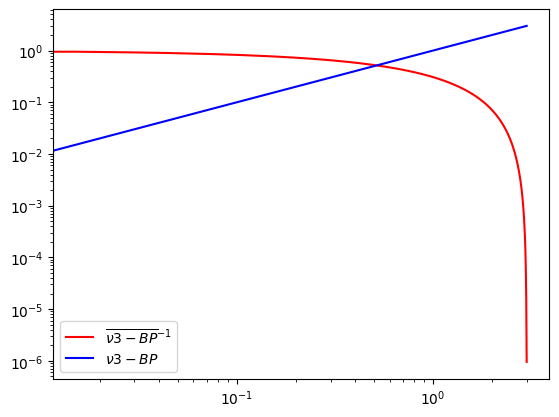

In [7]:
X=np.linspace(0,3,200)
plt.plot(X,vectorised_barnu3BP_inv(X),label=r"$\overline{\nu3-BP}^{-1}$",color="red")
plt.loglog(X,barnu3BP(vectorised_barnu3BP_inv(X)),label=r"$\nu3-BP$",color="blue")
plt.legend()

KeyboardInterrupt: 

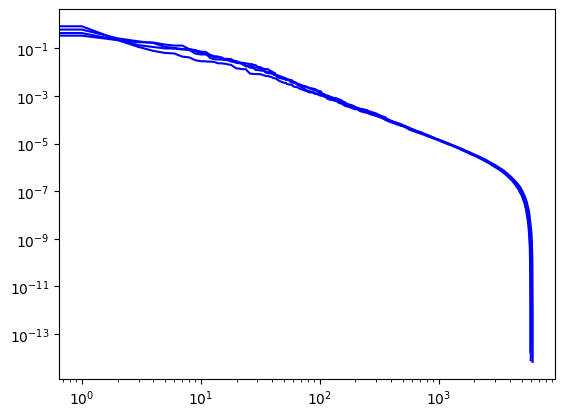

In [8]:
NbSample=5
for i in range(NbSample):
     W=threebeta(c,b,a,2000)
     sumW=np.sum(W)
     Y=np.sort(W)
     Y=Y[::-1]
     plt.loglog(Y,color='blue')
  
X=np.linspace(0,3,100)
plt.plot(X,vectorised_barnu3BP_inv(X),label=r"$\overline{\nu3-BP}^{-1}$",color="red")

plt.title('Loglog of the weights by decreasing order')
plt.xlabel('order')
plt.ylabel('$W_i$')
plt.legend()
plt.show()

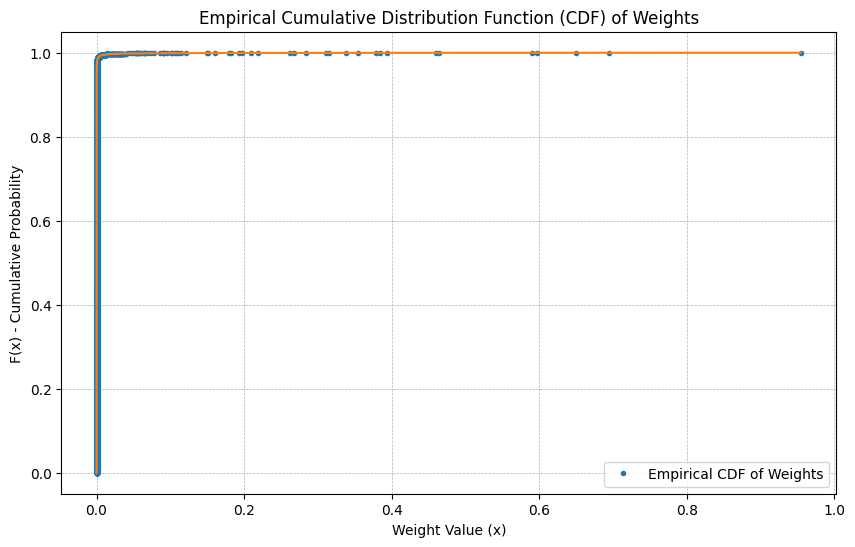

In [ ]:
def plot_empirical_cdf(weights, label='Empirical CDF'):
    """
    Calculates and plots the empirical Cumulative Distribution Function (CDF)
    for a given set of weights.

    Args:
        weights (np.ndarray): An array of sampled weights.
        label (str): The label to use for the plot legend.
    """
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)

    # Sort the weights in ascending order
    sorted_weights = np.sort(weights)

    # Calculate the cumulative probabilities.
    # For n weights, the probabilities are 1/n, 2/n, ..., n/n.
    cumulative_prob = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    
    # Plot the sorted weights against their cumulative probability
    plt.plot(sorted_weights, cumulative_prob, marker='.', linestyle='none', label=label)
    
    # Add a stairstep line for better visualization of the CDF
    plt.step(sorted_weights, cumulative_prob, where='post')

    plt.title('Empirical Cumulative Distribution Function (CDF) of Weights')
    plt.xlabel('Weight Value (x)')
    plt.ylabel('F(x) - Cumulative Probability')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

weight=[]
NbSample=5
for i in range(NbSample):
     W=threebeta(c,b,a,2000)
     weight.extend(W)
weight = np.array(weight)
plot_empirical_cdf(weight, label='Empirical CDF of Weights')

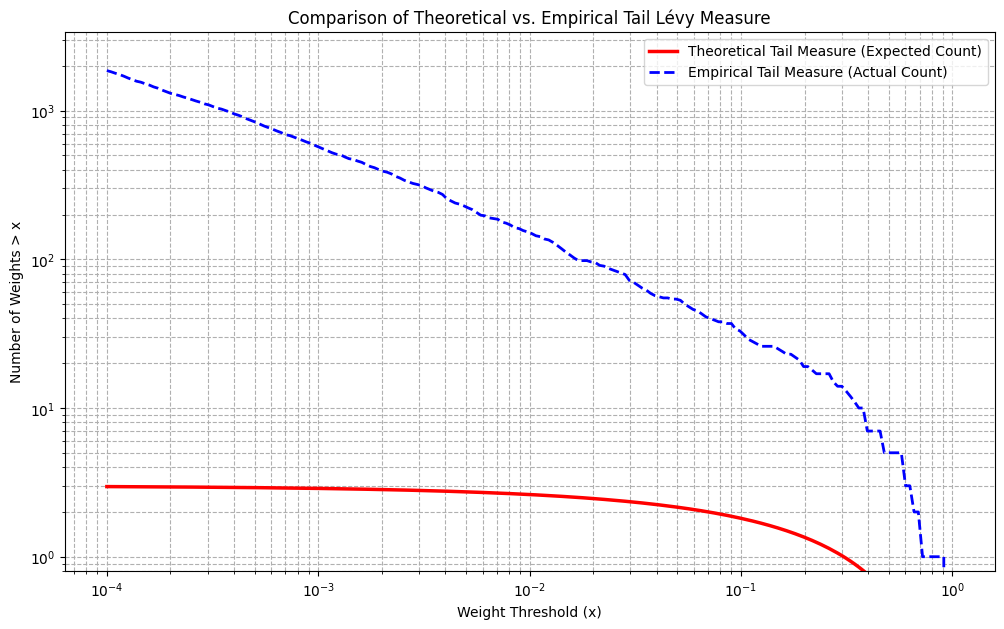

In [ ]:
def plot_tail_measure_comparison(weights):
    """
    Compares the empirical tail measure from a sample to the theoretical one.

    This function plots:
    1. The theoretical expected number of weights > x.
    2. The actual number of weights > x from your sample.
    
    If the sampler is correct, these two curves should match closely.
    """
    plt.figure(figsize=(12, 7))
    
    # 1. Generate the theoretical curve
    # Create a range of thresholds 'x' on a log scale
    x_vals = np.logspace(-4, 0, 200) 
    # Calculate the expected number of weights > x for each threshold
    theoretical_counts = barnu3BP(x_vals)
    
    plt.loglog(x_vals, theoretical_counts, 'r-', linewidth=2.5, label='Theoretical Tail Measure (Expected Count)')

    # 2. Generate the empirical curve from the sample
    # For each threshold in x_vals, count how many weights are larger
    empirical_counts = [np.sum(weights > x) for x in x_vals]
    
    plt.loglog(x_vals, empirical_counts, 'b--', linewidth=2, label='Empirical Tail Measure (Actual Count)')

    plt.title('Comparison of Theoretical vs. Empirical Tail Lévy Measure')
    plt.xlabel('Weight Threshold (x)')
    plt.ylabel('Number of Weights > x')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.ylim(bottom=0.8) # Start y-axis at just below 1 for better log view
    plt.show()

plot_tail_measure_comparison(weight)

In [9]:
eta=5
ksi=2
n_max=20
k_max=10



/var/folders/f1/j6lff07s4rz0h9k3nf2mqttm0000gn/T/ipykernel_48240/1257093046.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


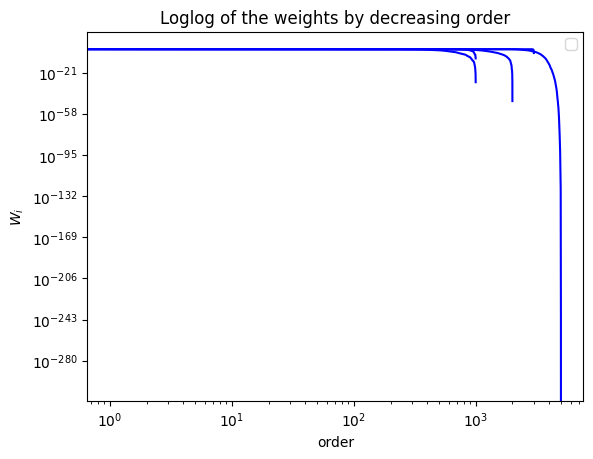

In [23]:
NbSample=5
for i in range(NbSample):
    W=rapidbeta(eta,ksi)
    Y=np.sort(W)
    Y=Y[::-1]
    plt.loglog(Y,color='blue')
  
X=np.arange(0,1e3,20)
#plt.loglog(X,inverse_barnu3BP(X),label=r"$\bar\nu^{-1}$",color="red")

plt.title('Loglog of the weights by decreasing order')
plt.xlabel('order')
plt.ylabel('$W_i$')
plt.legend()
plt.show()